# Tiny model, 2 class

## Using pytorch lightning

In [1]:
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt

import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger

import torchmetrics

torch.cuda.is_available()

True

In [2]:
torch.cuda.get_device_name(0)

'NVIDIA A10'

In [3]:
%run datasets.ipynb

import webdataset as wds

# training set has ~5k samples
BATCH_SIZE = auto_batch_size()
print("Batch size:", BATCH_SIZE)

dataset = wds.WebDataset(str(DATASET_ROOT / "california_tiny_train.tar"))\
    .decode("torchrgb").to_tuple("jpg", "json")

# Transform the labels to either ncal or scal
def to_img_label(sample):
    img, target = sample
    label = 0 if target["district"].lower() in ["alameda", "contra costa", "marin", "napa", "san francisco", "san mateo", "santa clara", "solano", "sonoma", "sacramento"] else 1
    # TODO: this is where we transform the image
    return img, label

dataset = dataset.map(to_img_label)
dataset = dataset.batched(BATCH_SIZE)

# Visualize a few loaded samples
dataloader = wds.WebLoader(dataset, batch_size=None, num_workers=0)
#dataloader = dataloader.unbatched().shuffle(1000).batched(BATCH_SIZE)

for inputs, targets in dataloader:
    print(inputs.shape, targets.shape)
    break

Batch size: 128
torch.Size([128, 3, 640, 640]) torch.Size([128])


In [4]:
# Define a LightningModule for the classifier
class NcalScalClassifierMnet3(L.LightningModule):
    def __init__(self):
        super().__init__()

        mnet3 = models.mobilenet_v3_large(weights="IMAGENET1K_V2")

        self.features = mnet3.features
        self.avgpool = mnet3.avgpool
        self.classifier = nn.Sequential(
            nn.Linear(mnet3.classifier[0].in_features, 1280),
            nn.Hardswish(inplace=True),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(1280, 2),
        )

        torch.nn.init.xavier_uniform_(self.classifier[0].weight)
        torch.nn.init.xavier_uniform_(self.classifier[3].weight)

        self.accuracy = torchmetrics.classification.Accuracy(task='multiclass', num_classes=2)

    def forward(self, x):
        with torch.no_grad():
            x = self.features(x)
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        z = self.forward(x)
        self.accuracy(z, y)
        self.log('train_acc_step', self.accuracy, prog_bar=True)

        loss = nn.CrossEntropyLoss()(z, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        z = self.forward(x)
        self.accuracy(z, y)
        self.log('test_acc', self.accuracy, on_step=False, on_epoch=True)

        test_loss = nn.CrossEntropyLoss()(z, y)
        self.log("test_loss", test_loss, prog_bar=True)
        return test_loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

In [5]:
class NcalScalClassifierEn2(L.LightningModule):
    def __init__(self):
        super().__init__()

        self.en2 = models.efficientnet_v2_m(weights="IMAGENET1K_V1")
        self.en2.classifier = nn.Sequential(
            # Default dropout: s=0.2, m=0.3, l=0.4
            nn.Dropout(p=0.3, inplace=True),
            nn.Linear(self.en2.classifier[1].in_features, 2),
        )

        nn.init.xavier_uniform_(self.en2.classifier[1].weight)
        nn.init.zeros_(self.en2.classifier[1].bias)

        self.accuracy = torchmetrics.classification.Accuracy(task='multiclass', num_classes=2)

    def forward(self, x):
        with torch.no_grad():
            x = self.en2.features(x)
            x = self.en2.avgpool(x)
            x = torch.flatten(x, 1)
        x = self.en2.classifier(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        z = self.forward(x)
        self.accuracy(z, y)
        self.log('train_acc_step', self.accuracy, prog_bar=True)

        loss = nn.CrossEntropyLoss()(z, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        z = self.forward(x)
        self.accuracy(z, y)
        self.log('test_acc', self.accuracy, on_step=False, on_epoch=True)

        test_loss = nn.CrossEntropyLoss()(z, y)
        self.log("test_loss", test_loss, prog_bar=True, on_epoch=True)
        return test_loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)


In [11]:
mnet3_model = NcalScalClassifierMnet3()
logger = TensorBoardLogger("tiny_2class_lightning")
trainer = L.Trainer(
    max_epochs=10,
    #deterministic=True,
    logger=logger,
    log_every_n_steps=5,
)
trainer.fit(model=mnet3_model, train_dataloaders=dataloader)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|████████████████████████████████████████████████████████████████████████| 21.1M/21.1M [00:00<00:00, 48.1MB/s]
You are using a CUDA device ('NVIDIA A10') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: tiny_2class_lightning/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | features   | Sequential         | 3.0 M 
1 | avgpool    | AdaptiveAvgPool2d  | 0     
2 | classifier | Sequential         | 1.2 M 
3 | accuracy   | MulticlassAccuracy | 0 

Epoch 9: : 40it [00:52,  1.31s/it, v_num=0, train_acc_step=0.769, train_loss=0.542]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: : 40it [00:52,  1.32s/it, v_num=0, train_acc_step=0.769, train_loss=0.542]


In [24]:
en2_model = NcalScalClassifierEn2()
logger = TensorBoardLogger("tiny_2class_lightning")
trainer = L.Trainer(
    max_epochs=10,
    #deterministic=True,
    logger=logger,
    log_every_n_steps=5,
)
trainer.fit(model=en2_model, train_dataloaders=dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | en2      | EfficientNet       | 52.9 M
1 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
52.9 M    Trainable params
0         Non-trainable params
52.9 M    Total params
211.444   Total estimated model params size (MB)


Epoch 9: : 40it [01:54,  2.86s/it, v_num=0, train_acc_step=0.731, train_loss=0.510]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: : 40it [01:54,  2.87s/it, v_num=0, train_acc_step=0.731, train_loss=0.510]


In [6]:
# Load the test set
test_dataset = wds.WebDataset(str(DATASET_ROOT / "california_tiny_test.tar"))\
    .decode("torchrgb").to_tuple("jpg", "json")
test_dataset = test_dataset.map(to_img_label).batched(BATCH_SIZE)
test_dataloader = wds.WebLoader(dataset, batch_size=None, num_workers=0)
#dataloader = dataloader.unbatched().shuffle(1000).batched(BATCH_SIZE)

for inputs, targets in test_dataloader:
    print(inputs.shape, targets.shape)
    break

torch.Size([128, 3, 640, 640]) torch.Size([128])


In [22]:
mnet3_model = NcalScalClassifierMnet3.load_from_checkpoint("mnet3_checkpoint_version_0.ckpt")
trainer.test(model=mnet3_model, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: : 40it [00:47,  1.20s/it]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8000392317771912     │
│         test_loss         │    0.4450194537639618     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4450194537639618, 'test_acc': 0.8000392317771912}]

In [27]:
en2_model = NcalScalClassifierEn2.load_from_checkpoint("en2_checkpoint_version_0.ckpt")
trainer.test(model=en2_model, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: : 40it [01:41,  2.53s/it]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7335164546966553     │
│         test_loss         │     0.526933491230011     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.526933491230011, 'test_acc': 0.7335164546966553}]

In [ ]:
predict_dataloader = wds.WebLoader(test_dataset.map(lambda x, y: x), batch_size=None, num_workers=0)

for inputs in predict_dataloader:
    print(inputs.shape)
    break

In [46]:
# Find the training examples that model gets the most wrong
mnet3_model = NcalScalClassifierMnet3.load_from_checkpoint("checkpoints/mnet3_checkpoint_version_0.ckpt")
mnet3_model.eval()

from typing import NamedTuple, List
class PredictedSample(NamedTuple):
    batch_idx: int
    sample_idx: int
    prediction: List
    loss: float

all_predicted_samples = []

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs = inputs.to("cuda")
        outputs = mnet3_model(inputs)
        outputs = outputs.to("cpu")

        loss_tensor = torch.nn.CrossEntropyLoss(reduction='none')(outputs, targets)
        for i, loss in enumerate(loss_tensor):
            ps = PredictedSample(
                batch_idx=batch_idx,
                sample_idx=i,
                prediction=outputs[i].tolist(),
                loss=loss.item(),
            )
            all_predicted_samples.append(ps)

        print(batch_idx)

# Sort the samples by loss
sorted_samples = sorted(all_predicted_samples, key=lambda x: x.loss, reverse=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


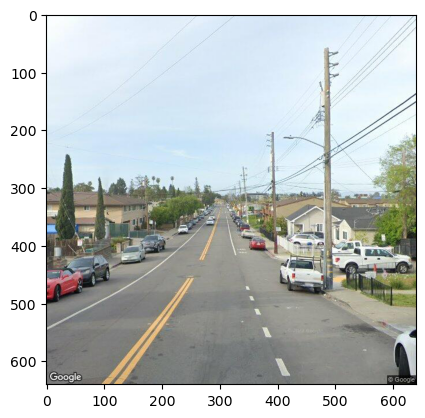

Loss: 2.706787586212158
Target: 0
Pred: [-1.4901843070983887, 1.1475203037261963]


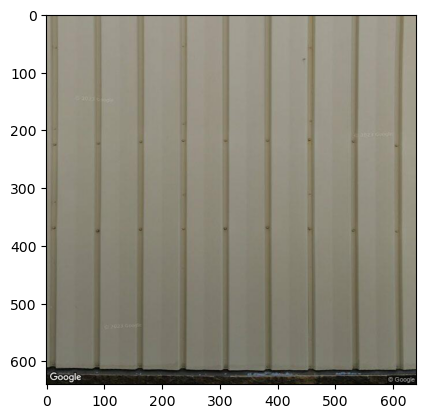

Loss: 2.769479513168335
Target: 0
Pred: [-1.532379388809204, 1.172353982925415]


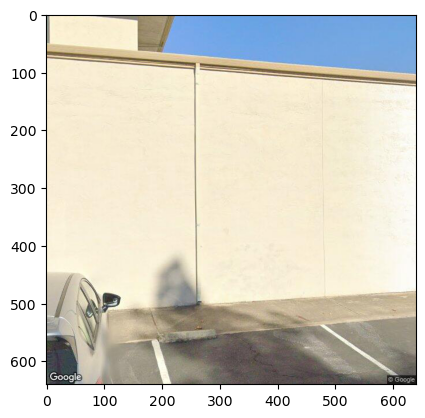

Loss: 2.7363696098327637
Target: 0
Pred: [-1.3555904626846313, 1.3137786388397217]


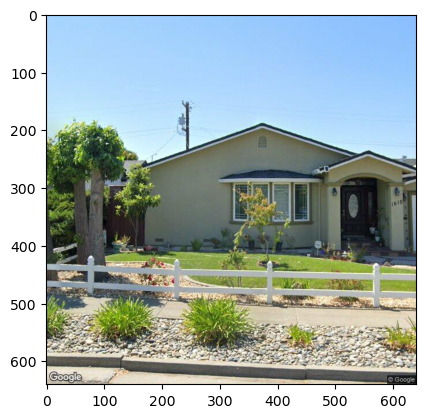

Loss: 2.6884658336639404
Target: 0
Pred: [-1.4212243556976318, 1.1968350410461426]


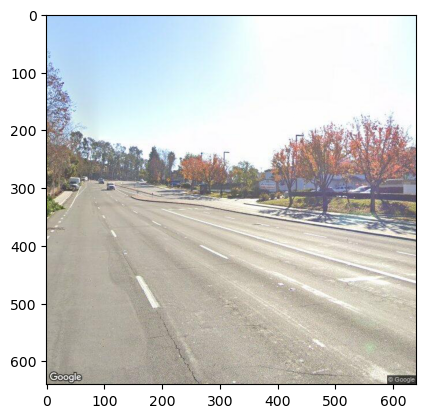

Loss: 3.0991175174713135
Target: 1
Pred: [1.5526236295700073, -1.5003567934036255]


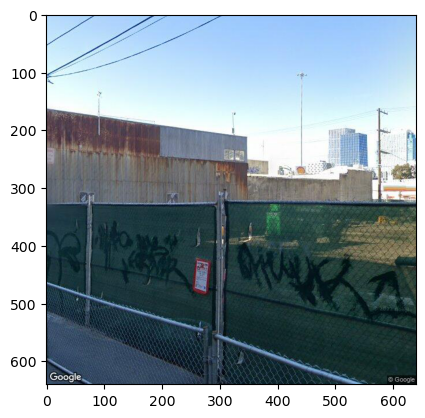

Loss: 3.2827939987182617
Target: 0
Pred: [-1.787834644317627, 1.4567139148712158]


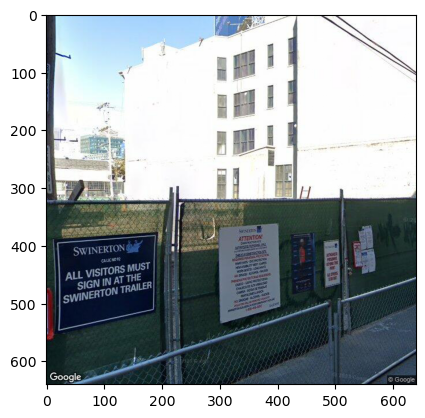

Loss: 2.8842415809631348
Target: 0
Pred: [-1.6098992824554443, 1.2168221473693848]


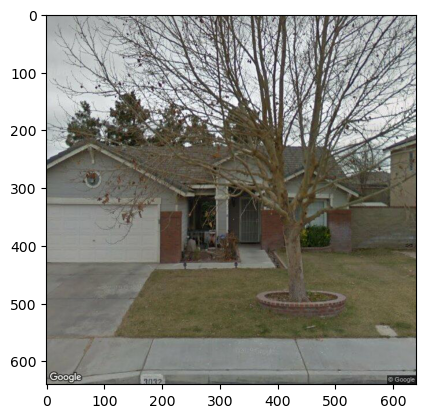

Loss: 2.7838408946990967
Target: 1
Pred: [1.2289156913757324, -1.491132140159607]


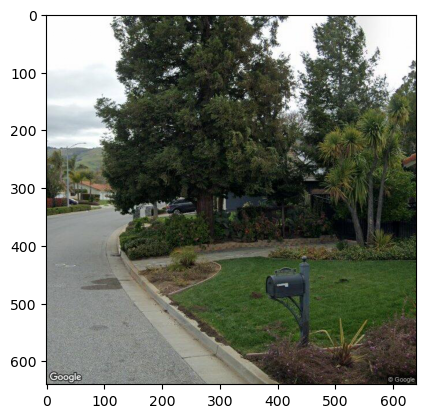

Loss: 2.7659428119659424
Target: 0
Pred: [-1.5730490684509277, 1.1279107332229614]


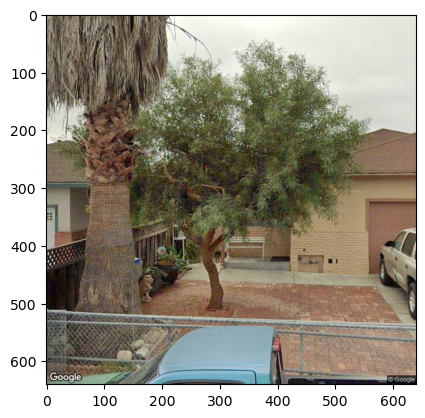

Loss: 2.6033108234405518
Target: 0
Pred: [-1.4726184606552124, 1.0537810325622559]


In [47]:
# Visualize the top 10 most wrong samples
to_viz = sorted_samples[:10]

should_continue = True
for batch_idx, (inputs, targets) in enumerate(dataloader):
    for ps in to_viz:
        if batch_idx != ps.batch_idx:
            continue
        # select the sample idx
        selected = inputs[ps.sample_idx]
        selected = selected.permute(1, 2, 0)
        plt.imshow(selected)
        plt.show()

        print("Loss:", ps.loss)
        print("Target:", targets[ps.sample_idx].item())
        print("Pred:", ps.prediction)


In [ ]:
# Is cross entropy correct?
l = torch.nn.CrossEntropyLoss()
[
    l(torch.tensor([[-1., 1.]]), torch.tensor([1])),
    l(torch.tensor([[-1., 10.]]), torch.tensor([1])),
    l(torch.tensor([[9., 10.]]), torch.tensor([1])),
    l(torch.tensor([[1., -1.]]), torch.tensor([1])),
    l(torch.tensor([[1., -1.]]), torch.tensor([0])),
    l(torch.tensor([[-1.4902,  1.1475]]), torch.tensor([1])),
    l(torch.tensor([[-0.5829, 0.3491]]), torch.tensor([1])),
]


[tensor(0.1269),
 tensor(1.6689e-05),
 tensor(0.3133),
 tensor(2.1269),
 tensor(0.1269),
 tensor(0.0691),
 tensor(0.3320)]